In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib as mpl
mpl.style.use('style.mcstyle')
import matplotlib.pyplot as plt
from os.path import join
import Pk_library as PKL
import h5py
import yaml
from tqdm import tqdm

In [2]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'

### Load and compare inference modules

In [3]:
nbody = 'mtnglike'
sim = 'fastpm'
tracer = 'ngc_lightcone'
summaries = '+'.join(['Pk0', 'Pk2'])
kmax = 0.5

modelpath = join(wdir, nbody, sim, 'models', tracer,
                 summaries, f'kmax-{kmax:.1f}')

In [4]:
# load model configurations
cfgpath = '/home/x-mho1/git/ltu-cmass/cmass/conf/net/tuning.yaml'
with open(cfgpath, 'r') as file:
    config = yaml.safe_load(file)

In [5]:
netpath = join(modelpath, 'nets')
converged = {}
for m in os.listdir(netpath):
    if os.path.isfile(join(netpath, m, 'posterior.pkl')):
        log_prob = float(np.loadtxt(join(netpath, m, 'log_prob_test.txt')))
        converged[m] = log_prob
print(f'Found {len(converged)} converged models')

Found 145 converged models


In [25]:
idx = [int(m.split('-')[-1]) for m in sorted(converged)]
log_probs = [converged[m] for m in sorted(converged)]
cfgs = [config[i] for i in idx]
mcfgs = [c['model'] for c in cfgs]
log_probs = np.array(log_probs)
mcfgs = np.array(mcfgs)

In [26]:
import pprint

top_10_indices = np.argsort(log_probs)[-10:]
top_10_configs = [cfgs[i] for i in top_10_indices]
pprint.pprint(top_10_configs)

[{'_idx': 154,
  'fcn_depth': 2,
  'fcn_width': 25,
  'hidden_features': 10,
  'model': 'gf',
  'num_transforms': 6},
 {'_idx': 124,
  'fcn_depth': 3,
  'fcn_width': 50,
  'hidden_features': 32,
  'model': 'sospf',
  'num_transforms': 6},
 {'_idx': 95,
  'fcn_depth': 1,
  'fcn_width': 25,
  'hidden_features': 17,
  'model': 'gf',
  'num_transforms': 3},
 {'_idx': 197,
  'fcn_depth': 3,
  'fcn_width': 39,
  'hidden_features': 25,
  'model': 'nsf',
  'num_transforms': 4},
 {'_idx': 147,
  'fcn_depth': 1,
  'fcn_width': 20,
  'hidden_features': 24,
  'model': 'nsf',
  'num_transforms': 4},
 {'_idx': 46,
  'fcn_depth': 2,
  'fcn_width': 28,
  'hidden_features': 28,
  'model': 'nsf',
  'num_transforms': 5},
 {'_idx': 44,
  'fcn_depth': 1,
  'fcn_width': 17,
  'hidden_features': 16,
  'model': 'nsf',
  'num_transforms': 7},
 {'_idx': 104,
  'fcn_depth': 2,
  'fcn_width': 17,
  'hidden_features': 22,
  'model': 'nsf',
  'num_transforms': 6},
 {'_idx': 36,
  'fcn_depth': 2,
  'fcn_width': 19,


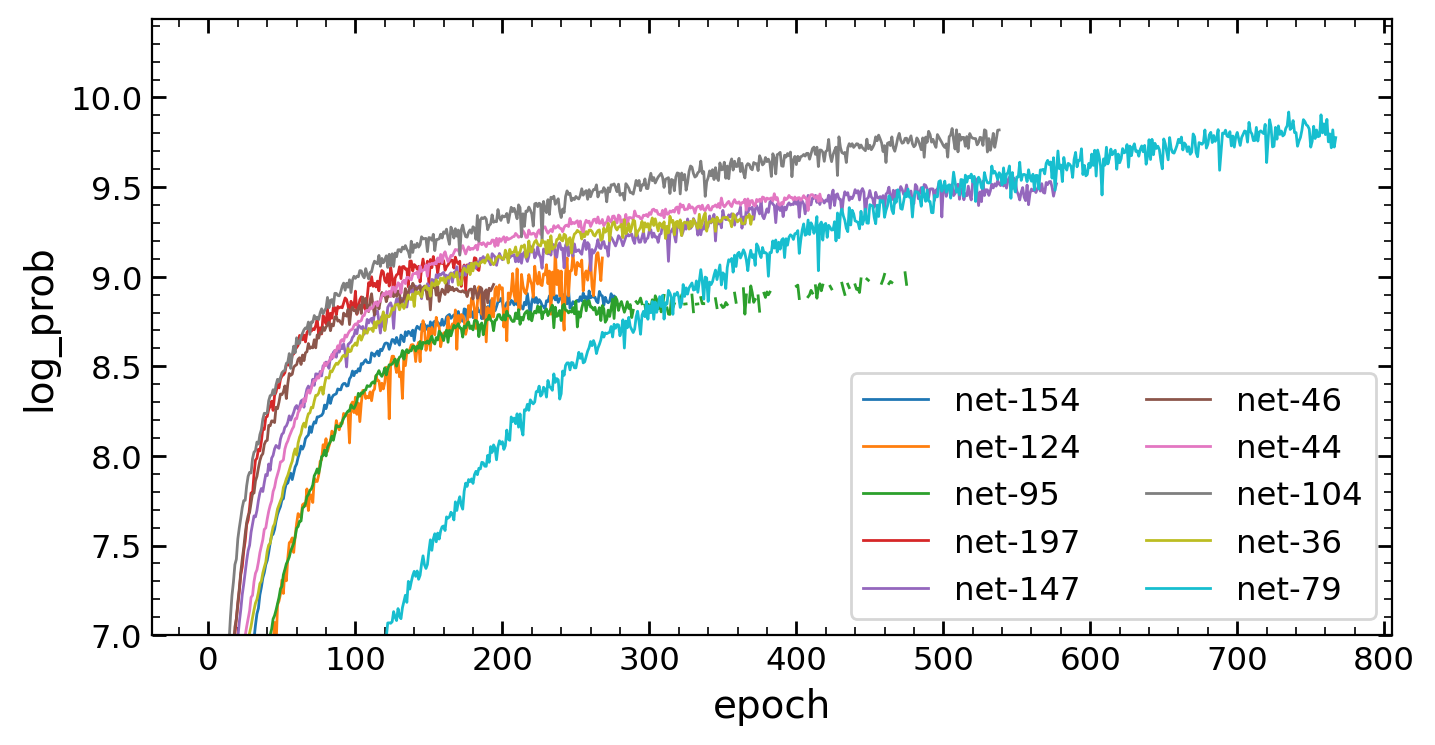

In [27]:
import json

f, ax = plt.subplots(1, 1, figsize=(8, 4))
for c in top_10_configs:
    idx = c["_idx"]
    summary_path = join(netpath, f'net-{idx}', 'summary.json')
    with open(summary_path, 'r') as file:
        summary = json.load(file)
        ax.plot(summary[0]['validation_log_probs'], label=f'net-{idx}', lw=1)

ax.set_ylim(7)
ax.set(xlabel='epoch', ylabel='log_prob')
ax.legend(ncol=2)

Text(0.5, 0, 'Log probability')

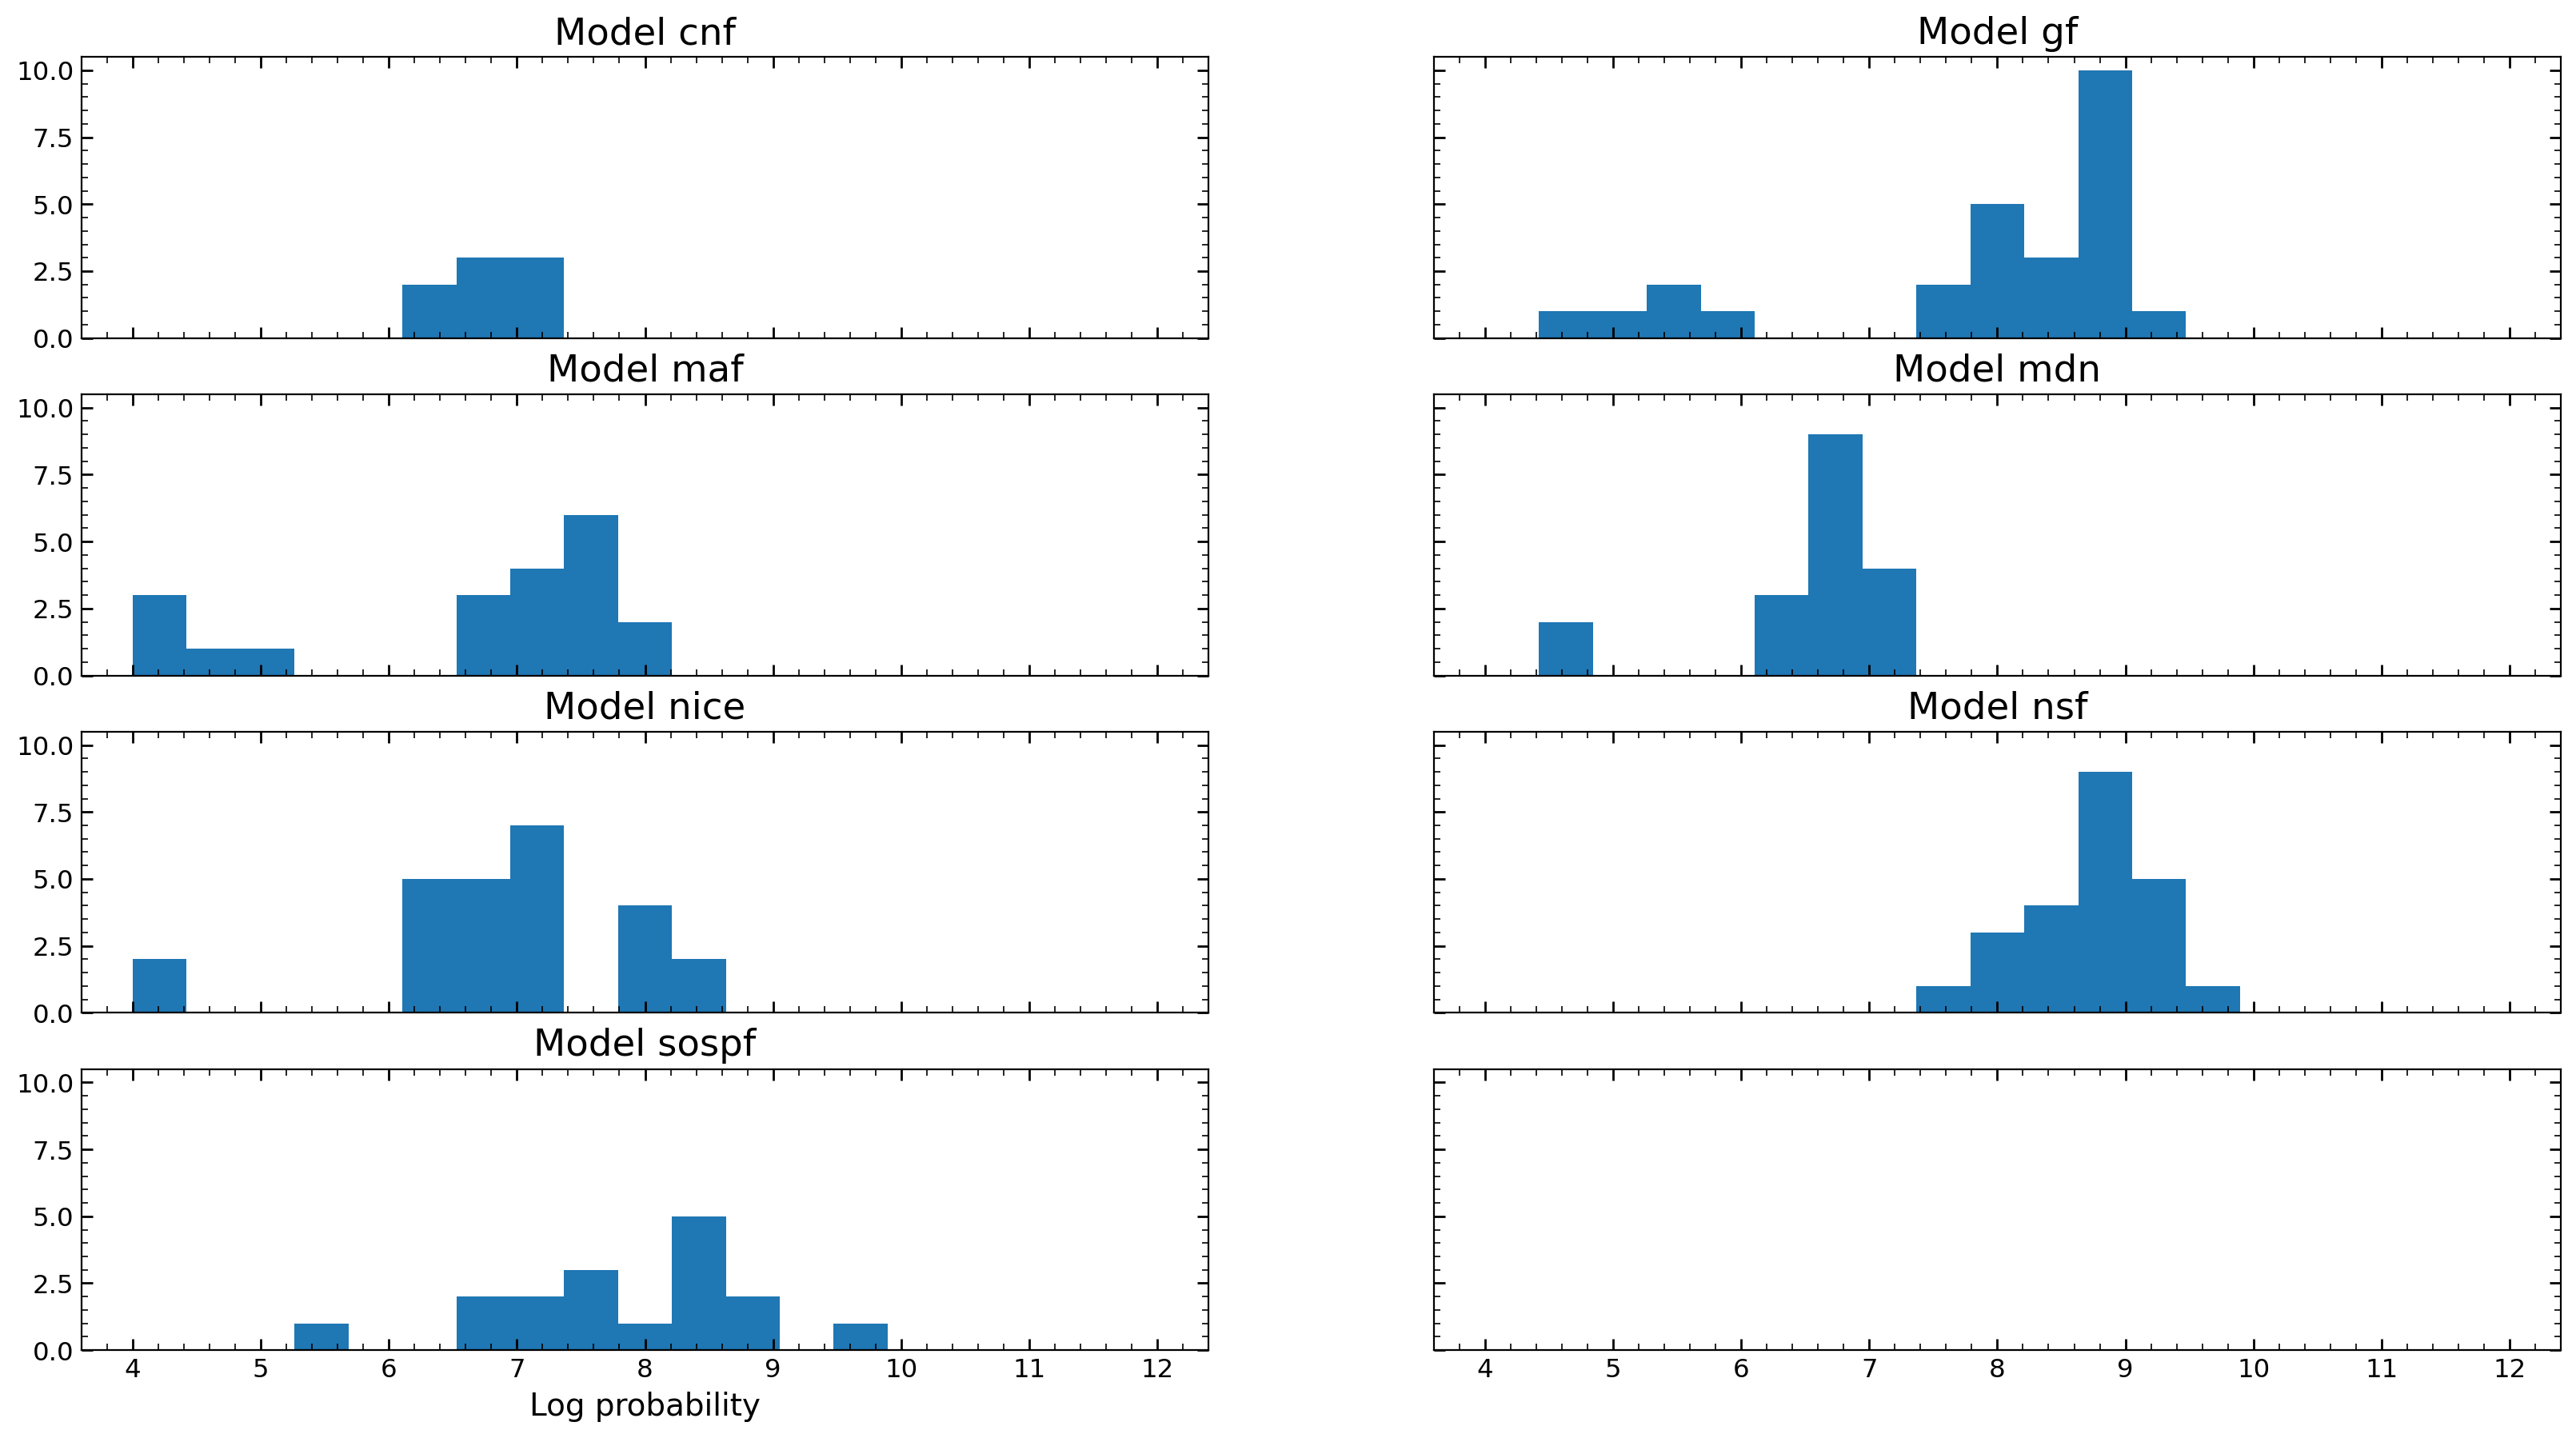

In [28]:
N = len(np.unique(mcfgs))
f, axs = plt.subplots(N//2+1, 2, figsize=(20, 3*N/2), sharex=True, sharey=True)
axs = axs.flatten()
bin_edges = np.linspace(4, 12, 20)
for i, m in enumerate(np.unique(mcfgs)):
    ax = axs[i]
    x = log_probs[mcfgs == m]
    ax.hist(x, bins=bin_edges, density=False)
    ax.set_title(f'Model {m}')
ax.set_xlabel('Log probability')

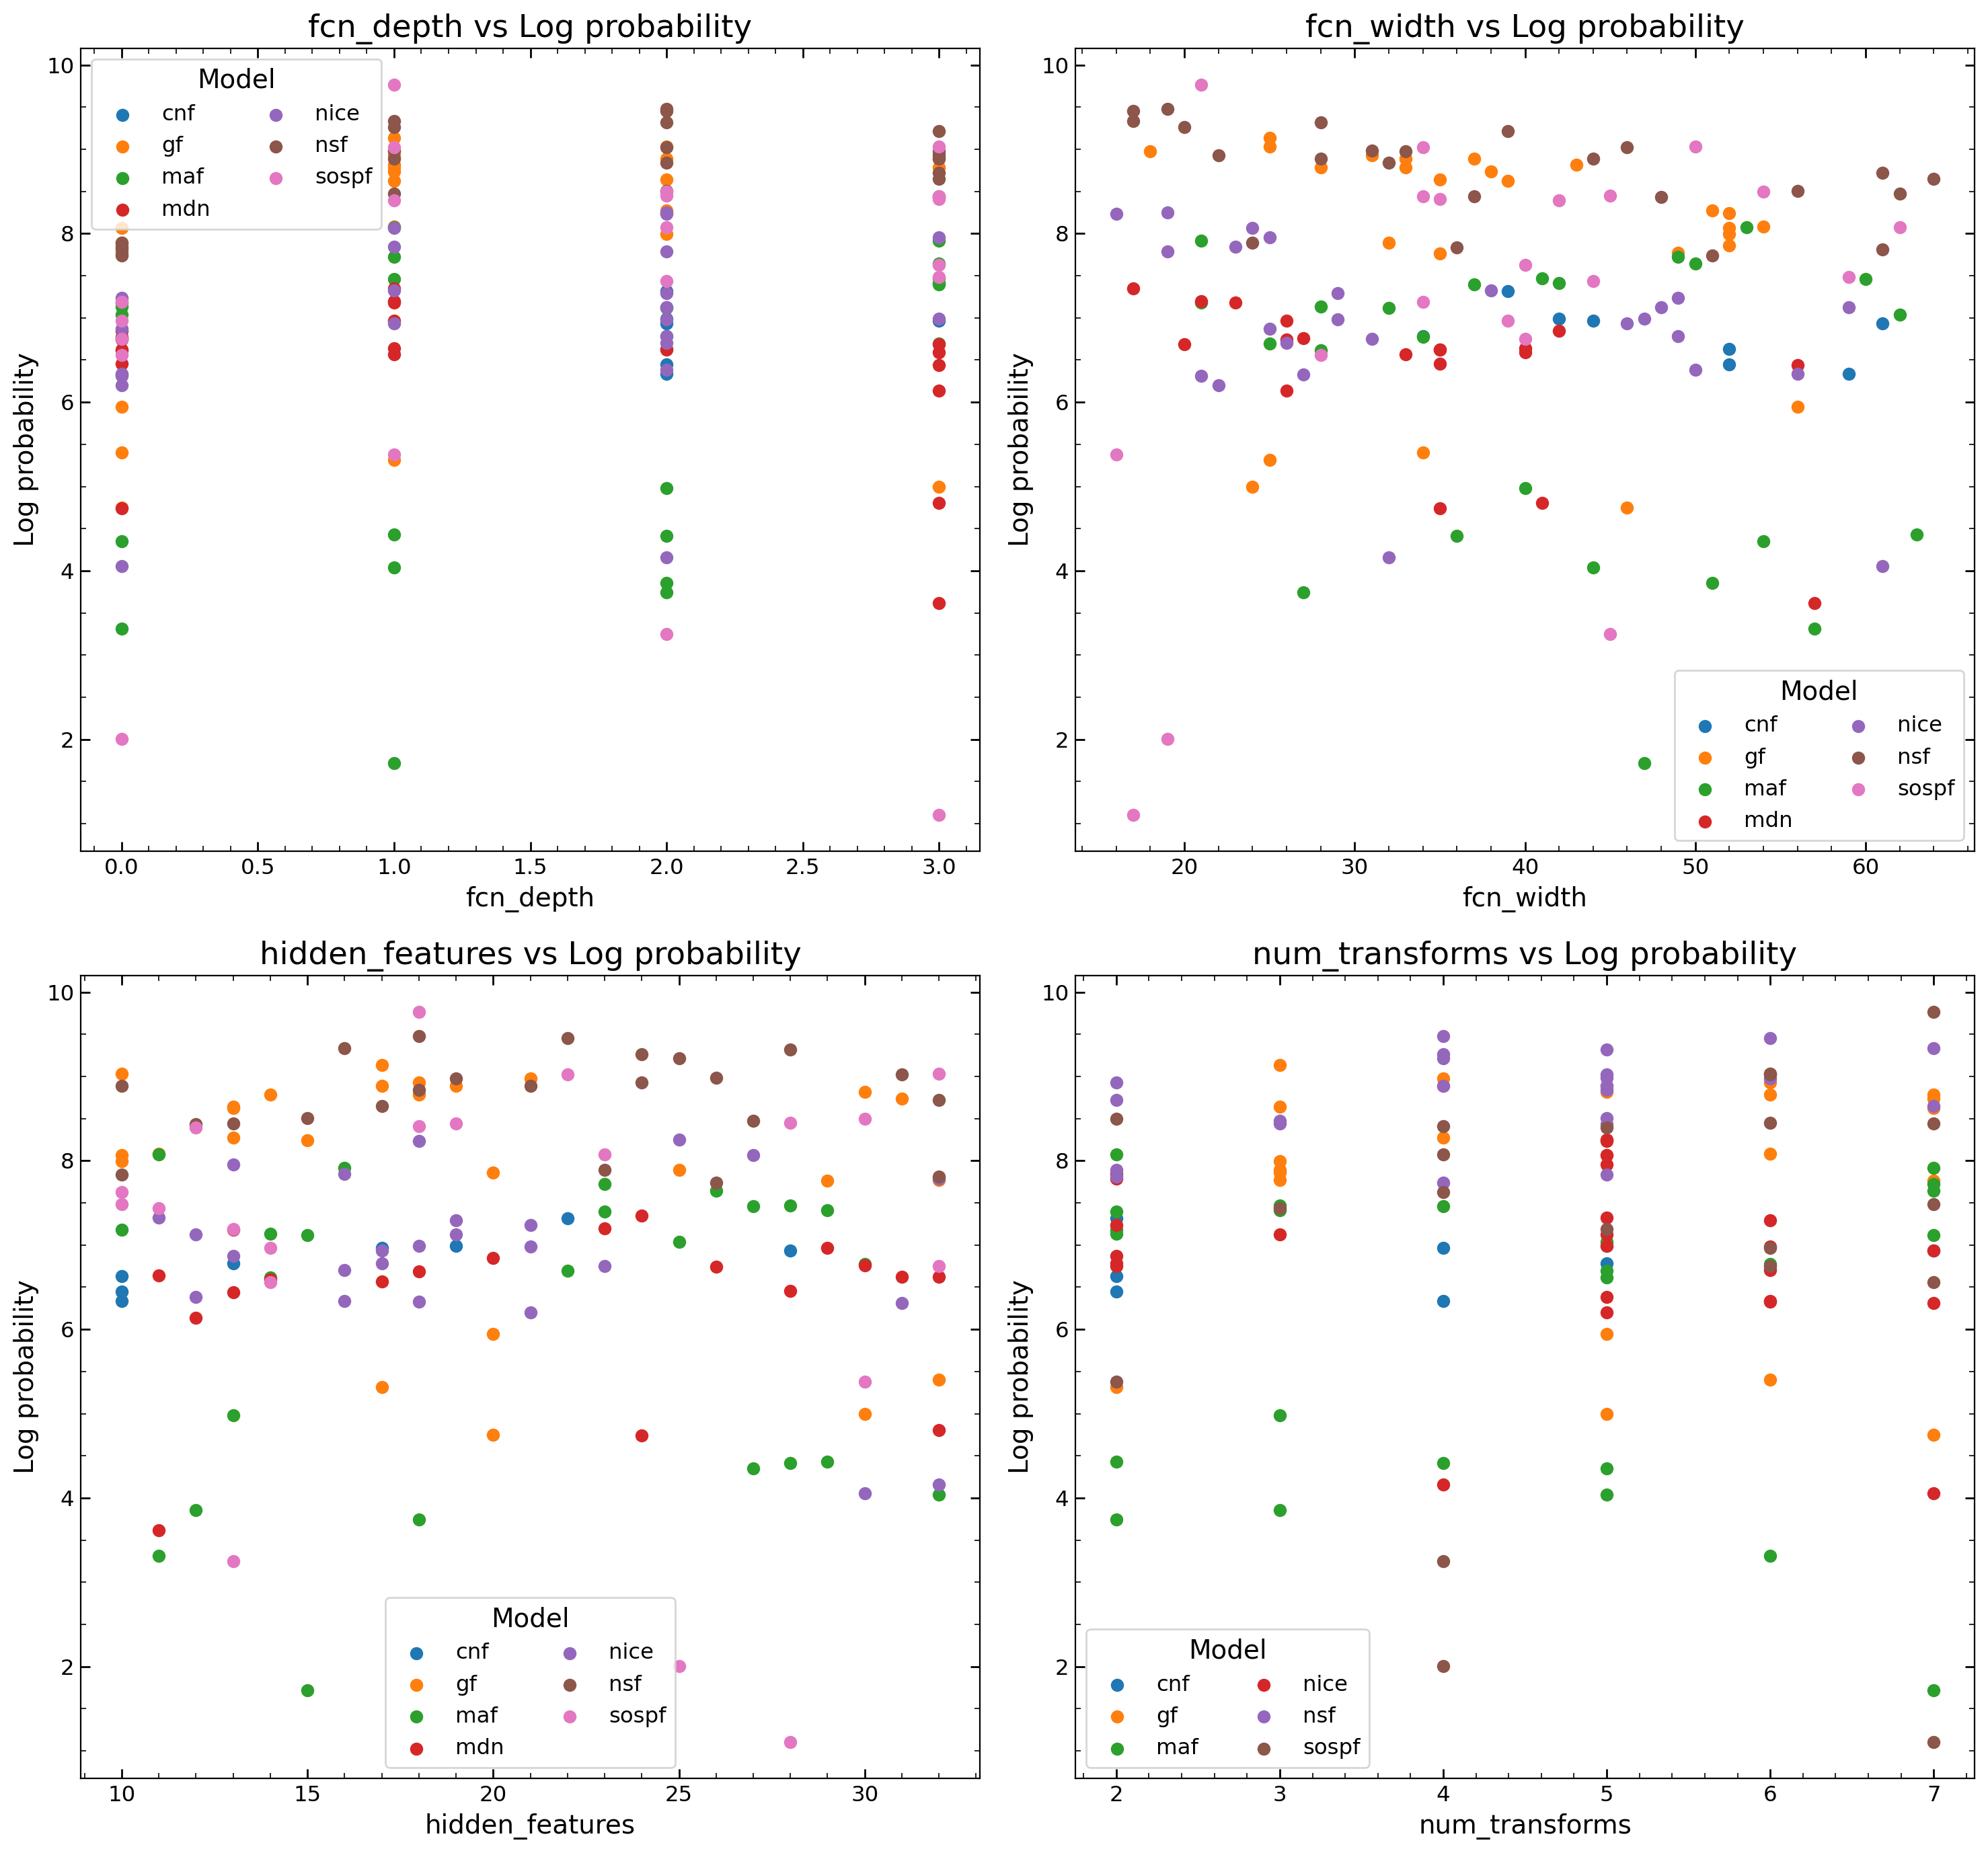

In [29]:
hypers = ['fcn_depth', 'fcn_width', 'hidden_features', 'num_transforms']
fig, axes = plt.subplots(len(hypers)//2, 2, figsize=(15, 7*len(hypers)/2))
axes = axes.flatten()

for i, hyper in enumerate(hypers):
    idxs = [i for i in range(len(cfgs)) if hyper in cfgs[i]]
    cs = [cfgs[i] for i in idxs]
    values = [c[hyper] for c in cs]
    model_types = [c['model'] for c in cs]
    lp = [log_probs[i] for i in idxs]
    values, model_types, lp = map(np.array, [values, model_types, lp])
    for m in np.unique(model_types):
        values_m = values[(model_types == m)]
        log_probs_m = lp[(model_types == m)]
        axes[i].scatter(values_m, log_probs_m, label=m)
    axes[i].set_xlabel(hyper)
    axes[i].set_ylabel('Log probability')
    axes[i].set_title(f'{hyper} vs Log probability')
    axes[i].legend(ncols=2, title="Model")

plt.tight_layout()
plt.show()

## check how slow each architecture is

In [18]:
from cmass.infer.validate import load_ensemble
ensemble = load_ensemble(modelpath, 200)

[13:34:07-INFO] Found 145 converged nets.
[13:34:07-INFO] Selected nets: ['net-79', 'net-36', 'net-104', 'net-44', 'net-46', 'net-147', 'net-197', 'net-95', 'net-124', 'net-154', 'net-180', 'net-66', 'net-5', 'net-177', 'net-70', 'net-117', 'net-12', 'net-16', 'net-113', 'net-10', 'net-198', 'net-31', 'net-110', 'net-59', 'net-18', 'net-141', 'net-144', 'net-199', 'net-171', 'net-47', 'net-106', 'net-161', 'net-68', 'net-131', 'net-128', 'net-1', 'net-116', 'net-50', 'net-123', 'net-28', 'net-145', 'net-130', 'net-114', 'net-175', 'net-81', 'net-3', 'net-96', 'net-140', 'net-23', 'net-52', 'net-138', 'net-35', 'net-194', 'net-98', 'net-88', 'net-48', 'net-173', 'net-170', 'net-93', 'net-186', 'net-86', 'net-55', 'net-24', 'net-6', 'net-112', 'net-146', 'net-87', 'net-129', 'net-157', 'net-25', 'net-142', 'net-94', 'net-152', 'net-139', 'net-151', 'net-108', 'net-102', 'net-11', 'net-90', 'net-2', 'net-69', 'net-83', 'net-58', 'net-135', 'net-53', 'net-100', 'net-38', 'net-92', 'net-168

In [19]:
xtest = np.load(join(modelpath, 'x_test.npy'))

In [20]:
flow_names = [str(type(ensemble.posteriors[i].nde.flow))
              for i in range(len(ensemble.posteriors))]
np.unique(flow_names, return_counts=True)

(array(["<class 'zuko.flows.autoregressive.MAF'>",
        "<class 'zuko.flows.continuous.CNF'>",
        "<class 'zuko.flows.coupling.NICE'>",
        "<class 'zuko.flows.gaussianization.GF'>",
        "<class 'zuko.flows.polynomial.SOSPF'>",
        "<class 'zuko.flows.spline.NSF'>", "<class 'zuko.mixtures.GMM'>"],
       dtype='<U39'),
 array([24,  8, 25, 26, 20, 23, 19]))

In [24]:
import time

Nsamp = 2000
times = []
for posterior in tqdm(ensemble.posteriors):
    start_time = time.time()
    posterior.sample(x=xtest[0:1], shape=Nsamp, show_progress_bars=False)
    end_time = time.time()
    times.append(end_time - start_time)

# print("Sampling times for each posterior:", times)

100%|██████████| 145/145 [02:29<00:00,  1.03s/it]


In [25]:
flow_names = np.array(flow_names)
times = np.array(times)/Nsamp

Text(0.5, 0, 'Time per sample (s)')

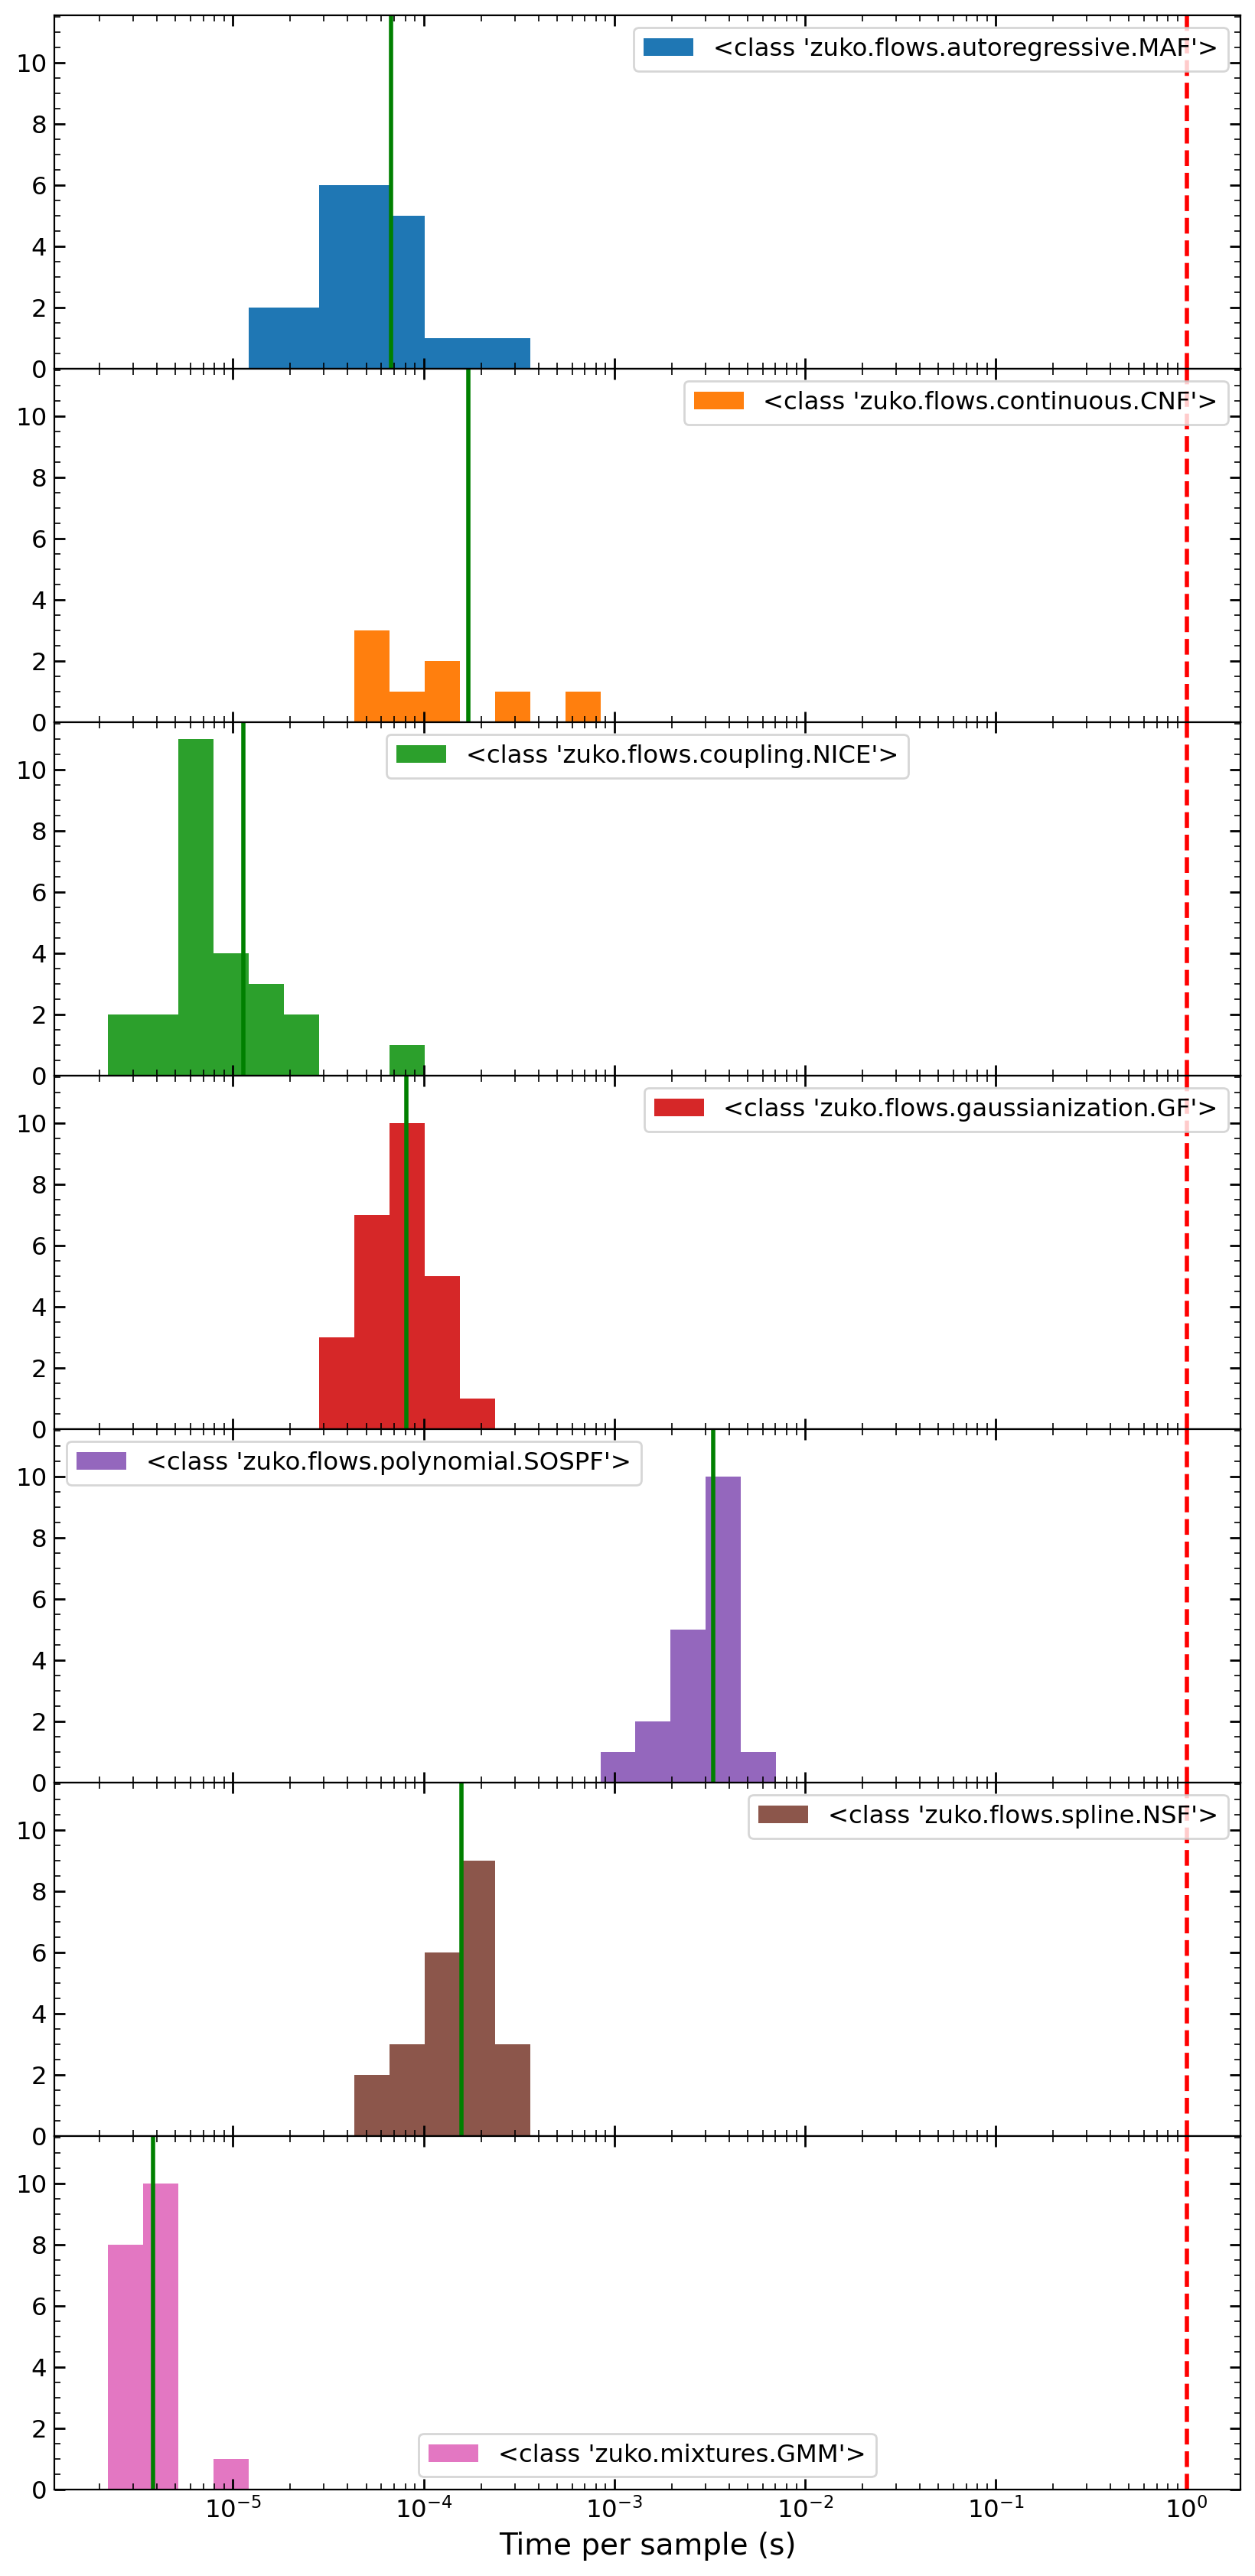

In [30]:
N = len(np.unique(flow_names))
f, axs = plt.subplots(N, 1,
                      sharex=True, sharey=True,
                      figsize=(10, 3*N),
                      gridspec_kw={'hspace': 0})
be = np.logspace(np.log10(times.min()), np.log10(times.max()), 20)
for i, m in enumerate(np.unique(flow_names)):
    ax = axs[i]
    ax.semilogx()
    mask = flow_names == m
    ax.hist(times[mask], bins=be, label=m,
            alpha=1, color=f'C{i}', density=False)
    ax.legend()
    ax.axvline(1, color='r', ls='--')
    ax.axvline(times[mask].mean(), color='g')
ax.set_xlabel('Time per sample (s)')